# Ethereum MainNet 블록을 Big-Query로 탐색하기

----

* **DATE** : 2021.11.10
* **AUTHOR** : Kang Sang Jae
* **Reference** : 

    * [Full relational diagram for Ethereum public data on Google BigQuery](https://medium.com/google-cloud/full-relational-diagram-for-ethereum-public-data-on-google-bigquery-2825fdf0fb0b)
    * [SQL On Ethereum: How To Work With All the Data From a Transaction](https://towardsdatascience.com/sql-on-ethereum-how-to-work-with-all-the-data-from-a-transaction-103f94f902e5)
    * [What is crypto data](https://towardsdatascience.com/what-is-crypto-data-fef70ecadf7b)
    * [Unlocking the Secrets of an Ethereum Transaction](https://medium.com/coinmonks/discovering-the-secrets-of-an-ethereum-transaction-64febb00935c)
    * [Decoding Ethereum smart contract data](https://towardsdatascience.com/decoding-ethereum-smart-contract-data-eed513a65f76)
    * [The data behind the NFT hype](https://towardsdatascience.com/the-data-behind-the-nft-hype-32f6f92c27cb)

### 환경설정하기

**reference**
* [IPython Magics For BigQuery](https://googleapis.dev/python/bigquery/latest/magics.html)
* [클라이언트 라이브러리 설치](https://cloud.google.com/bigquery/docs/visualize-jupyter)

````shell
pip install --upgrade 'google-cloud-bigquery[bqstorage,pandas]'
````

In [79]:
%matplotlib inline
import os
import json
import requests

import pandas as pd
import matplotlib.pyplot as plt

# GCP 인증서 다운 받기
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = (
    os.path.abspath("../keys/gcp.json"))

# Infura Key file
KEY_DICT = json.load(open("../keys/infura.json",'r'))

project_id = KEY_DICT['projectId']

In [ ]:
%load_ext google.cloud.bigquery

## 빅쿼리에서 관리하고 있는 전체 데이터셋 구조 

* reference : [db-diagram](https://dbdiagram.io/d/602e721380d742080a3b1265)

![](https://miro.medium.com/max/2000/1*e5NHRqew4lXNLQ7NAL7KIQ.png)

#### Contracts

이더리움 생태계 내 Contract 내용은 아래와 같습니다.

|column|type|mode|description|
|---|---|---|---|
|address	|STRING|	REQUIRED| Address of the contract	|
|bytecode	|STRING|	NULLABLE| Bytecode of the contract	|
|function_sighashes|	STRING|	REPEATED| 4-byte function signature hashes	|
|is_erc20|	BOOLEAN|	NULLABLE | Whether this contract is an ERC20 contract	|
|is_erc721|	BOOLEAN|	NULLABLE| Whether this contract is an ERC721 contract| 
|block_timestamp|	TIMESTAMP|	REQUIRED| Timestamp of the block where this contract was created	|
|block_number|	INTEGER|	REQUIRED| Block number where this contract was created	|
|block_hash|	STRING|	REQUIRED| Hash of the block where this contract was created|


#### 예시 1) 전체 ERC-20 토큰 컨트랙트의 수

In [11]:
%%bigquery

SELECT COUNT(*) as totalCount
FROM `bigquery-public-data.crypto_ethereum.contracts` 
WHERE is_erc20 = true

Downloading: 100%|██████████| 1/1 [00:03<00:00,  3.73s/rows]


,totalCount
0,202650


#### 예시 2) 전체 ERC-721(NFT) 토큰 컨트랙트의 수

In [12]:
%%bigquery

SELECT COUNT(*) as totalCount
FROM `bigquery-public-data.crypto_ethereum.contracts` 
WHERE is_erc721 = true

Downloading: 100%|██████████| 1/1 [00:03<00:00,  3.17s/rows]


,totalCount
0,4685


#### 예시 3) ERC-721 토큰 발행량의 시계열적 분석 

*아래와 같이 코드를 짜면, `erc721_df` 해당 데이터가 저장이 됩니다.*

In [13]:
%%bigquery erc721_df

SELECT address, block_timestamp	
FROM `bigquery-public-data.crypto_ethereum.contracts` 
WHERE is_erc721 = true

Downloading: 100%|██████████| 4685/4685 [00:03<00:00, 1225.73rows/s]


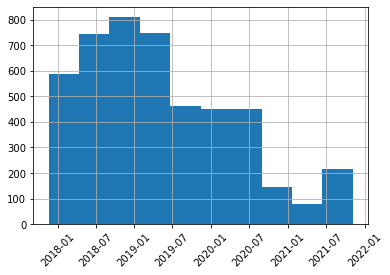

In [21]:
erc721_df.block_timestamp.hist()

plt.xticks(rotation=45)
plt.show()

#### 예시 4) Contract의 소스 코드 디컴파일링

* [Online Solidity Decompiler](https://ethervm.io/decompile)

![Imgur](https://i.imgur.com/nzJmbmS.png)

In [34]:
%%bigquery df

SELECT address, bytecode, block_timestamp	
FROM `bigquery-public-data.crypto_ethereum.contracts` 
WHERE is_erc721 = true 
  AND date(block_timestamp) = '2021-10-01'

Downloading: 100%|██████████| 2/2 [00:03<00:00,  1.66s/rows]


아래의 코드을 가지고, 디컴파일러에 돌리면, 해당 소스코드의 본 모습이 나온다. 가독성은 매우 나쁘지만 대충 어떤 동작을 할지를 알수 있다.

In [39]:
df.bytecode.iloc[0]

'0x6080604052600436106101e15760003560e01c806301ffc9a7146101e657806306fdde031461022e578063081812fc146102b8578063095ea7b3146102fe57806312cae7af1461033957806318160ddd146103bc57806323b872dd146103e35780632a85db55146104265780632f745c59146104d7578063313f3e541461051057806342842e0e1461053a5780634f6ccce71461057d57806354e09fb8146105a757806355f804b3146105d357806358eb512d146106845780636352211e146106ff5780636c0360eb1461072957806370a082311461073e578063715018a614610771578063729ad39e14610786578063733e193c146108345780637501f7411461084957806376a166261461085e57806379b6ed361461086657806381a7927e1461087b5780638da5cb5b146108905780638fe046db146108a557806391b7f5ed146108ba57806395d89b41146108e457806398d5fdca146108f9578063a0712d681461090e578063a22cb4651461092b578063b88d4fde14610966578063c87b56dd14610a37578063cc5c095c14610a61578063d76e46cb14610a76578063e985e9c514610a8b578063eb8d244414610ac6578063eeac8d8a14610adb578063f2fde38b14610b07578063f79ed94b14610b3a578063ffa1ad7414610b4f575b600080fd5b3480156101f257600080fd5

![Imgur](https://i.imgur.com/nzJmbmS.png)

#### Transaction

이더리움 생태계 내 Transaction 내용은 아래와 같습니다.

| column | type | mode | description |
| ---  | --- | --- | --- |
| hash | STRING | REQUIRED | Hash of the transaction | 
 | nonce | INTEGER | REQUIRED | The number of transactions made by the sender prior to this one | 
 | transaction_index | INTEGER | REQUIRED | Integer of the transactions index position in the block | 
 | from_address | STRING | REQUIRED | Address of the sender | 
 | to_address | STRING | NULLABLE | Address of the receiver. null when its a contract creation transaction | 
 | value | NUMERIC | NULLABLE | Value transferred in Wei | 
 | gas | INTEGER | NULLABLE | Gas provided by the sender | 
 | gas_price | INTEGER | NULLABLE | Gas price provided by the sender in Wei | 
 | input | STRING | NULLABLE | The data sent along with the transaction | 
 | receipt_cumulative_gas_used | INTEGER | NULLABLE | The total amount of gas used when this transaction was executed in the block | 
 | receipt_gas_used | INTEGER | NULLABLE | The amount of gas used by this specific transaction alone | 
 | receipt_contract_address | STRING | NULLABLE | The contract address created, if the transaction was a contract creation, otherwise null | 
 | receipt_root | STRING | NULLABLE | 32 bytes of post-transaction stateroot (pre Byzantium) | 
 | receipt_status | INTEGER | NULLABLE | Either 1 (success) or 0 (failure) (post Byzantium) | 
 | block_timestamp | TIMESTAMP | REQUIRED | Timestamp of the block where this transaction was in | 
 | block_number | INTEGER | REQUIRED | Block number where this transaction was in | 
 | block_hash | STRING | REQUIRED | Hash of the block where this transaction was in | 
 | max_fee_per_gas | INTEGER | NULLABLE | Total fee that covers both base and priority fees | 
 | max_priority_fee_per_gas | INTEGER | NULLABLE | Fee given to miners to incentivize them to include the transaction | 
 | transaction_type | INTEGER | NULLABLE | Transaction type | 
 | receipt_effective_gas_price | INTEGER | NULLABLE | The actual value per gas deducted from the senders account. Replacement of gas_price after EIP-1559 |

예제 1) OpenSEA에서의 NFT 거래 추적하기 

* reference : [opensea Tracking](https://opensea.io/assets/0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d/7357)

![Imgur](https://i.imgur.com/BwkZhYd.png)

![Imgur](https://i.imgur.com/0KOykTb.png)

우선 해당 거래에 대한 날짜와 transactionId를 가져온다

In [58]:
%%bigquery transaction_df

SELECT *
FROM `bigquery-public-data.crypto_ethereum.transactions` 
WHERE `hash` = '0xfd2d4e8c5037b2f20a80105d2f7c68f66e7e704fc2836320614f7fcc057ac930'
AND date(block_timestamp) = '2021-10-06'

Downloading: 100%|██████████| 1/1 [00:03<00:00,  3.87s/rows]


In [60]:
transaction_df.iloc[0]

hash                           0xfd2d4e8c5037b2f20a80105d2f7c68f66e7e704fc283...
nonce                                                                        657
transaction_index                                                            149
from_address                          0xfdec56e98be0b581aa429f615741edb77e736b95
to_address                            0x7be8076f4ea4a4ad08075c2508e481d6c946d12b
value                                             40400000000000000000.000000000
gas                                                                       329550
gas_price                                                           125301068868
input                          0xab834bab0000000000000000000000007be8076f4ea4...
receipt_cumulative_gas_used                                             13931933
receipt_gas_used                                                          238959
receipt_contract_address                                                    None
receipt_root                

* from_address => klove (구매자, 0xfdec56e98be0b581aa429f615741edb77e736b95) 
* to_address => Oversea에서 만든 거래 SmartContract
* value => 구매 금액
* input => 거래 요청에 대한 요청 정보

In [63]:
transaction_df.iloc[0].input

'0xab834bab0000000000000000000000007be8076f4ea4a4ad08075c2508e481d6c946d12b000000000000000000000000fdec56e98be0b581aa429f615741edb77e736b9500000000000000000000000035f0686c63f50707ea3b5bace186938e4e19f03a0000000000000000000000000000000000000000000000000000000000000000000000000000000000000000bc4ca0eda7647a8ab7c2061c2e118a18a936f13d000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000007be8076f4ea4a4ad08075c2508e481d6c946d12b00000000000000000000000035f0686c63f50707ea3b5bace186938e4e19f03a00000000000000000000000000000000000000000000000000000000000000000000000000000000000000005b3256965e7c3cf26e11fcaf296dfc8807c01073000000000000000000000000bc4ca0eda7647a8ab7c2061c2e118a18a936f13d0000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000001f400000000000000000000000000000

**ABI(Application Binary Interface) 방식**

SmartContract의 함수와 파라미터에 대한 MetaData를 정의해 Contract의 객체를 만들 수 있고 Contract의 함수를 호출할 수 있는 표준방법입니다.

Contract의 함수를 호출하기 위해서는 ABI Spec에 맞게 데이터를 변환해야 합니다. 데이터는 크게 함수에 대한 정보와 함수 호출에 사용할 인수로 구분합니다.

* 함수에 대한 정보 : 함수의 이름과 인수에 대한 type을 정의
* 인수 : 함수에서 사용할 인수

In [69]:
contract_address = '0x7be8076f4ea4a4ad08075c2508e481d6c946d12b'
abi = requests.get(f"https://api.etherscan.io/api?module=contract&action=getabi&address={contract_address}").json()

In [81]:
from web3 import Web3

In [92]:
# Main넷에 붙기
w3 = Web3(
    Web3.HTTPProvider(f"https://mainnet.infura.io/v3/{project_id}")
)

# Contract 가져오기
contract = w3.eth.contract(
    address=Web3.toChecksumAddress(contract_address), 
    abi=abi['result'])

In [91]:
contract.decode_function_input(transaction_df.iloc[0].input)

(<Function atomicMatch_(address[14],uint256[18],uint8[8],bytes,bytes,bytes,bytes,bytes,bytes,uint8[2],bytes32[5])>,
 {'addrs': ['0x7Be8076f4EA4A4AD08075C2508e481d6C946D12b',
   '0xFDeC56E98be0B581AA429f615741EdB77e736B95',
   '0x35F0686c63F50707Ea3b5baCe186938E4E19f03a',
   '0x0000000000000000000000000000000000000000',
   '0xBC4CA0EdA7647A8aB7C2061c2E118A18a936f13D',
   '0x0000000000000000000000000000000000000000',
   '0x0000000000000000000000000000000000000000',
   '0x7Be8076f4EA4A4AD08075C2508e481d6C946D12b',
   '0x35F0686c63F50707Ea3b5baCe186938E4E19f03a',
   '0x0000000000000000000000000000000000000000',
   '0x5b3256965e7C3cF26E11FCAf296DfC8807C01073',
   '0xBC4CA0EdA7647A8aB7C2061c2E118A18a936f13D',
   '0x0000000000000000000000000000000000000000',
   '0x0000000000000000000000000000000000000000'],
  'uints': [500,
   0,
   0,
   0,
   40400000000000000000,
   0,
   1633542299,
   0,
   97327860915522052421301856341972992756548292311523290562128467177038223858636,
   500,
   0,
   0,